In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

           symbol       close       volume
date                                      
2010-01-04   AAPL  214.009998  123432400.0
2010-01-04    ABT   54.459951   10829000.0
2010-01-04    AIG   29.889999    7750900.0
2010-01-04   AMAT   14.300000   18615100.0
2010-01-04   ARNC   16.650013   11512100.0


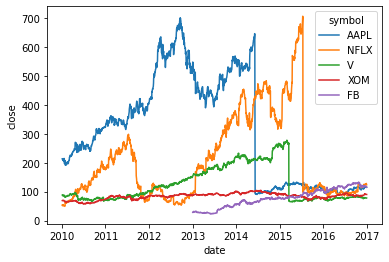

In [2]:
# Read in the data
data = pd.read_csv('https://assets.datacamp.com/production/repositories/1536/datasets/43d325fa67cde1d4d5de62adc108fceabaddf3cc/prices.csv', index_col=0)

# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
print(data.head())
#select a few stocks
stocks=['AAPL','FB','NFLX','XOM','V']
best_stocks=data[data.symbol.isin(stocks)]

# Loop through each column, plot its values over time
sns.lineplot(data=best_stocks,x='date',y='close',hue='symbol')
plt.show()